In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy.signal import medfilt2d

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
import glob
import math

In [4]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [5]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [6]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')


In [7]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))
    
print bases


[(0, 0), (0, 1), (0, 2), (0, 11), (0, 12), (0, 13), (0, 14), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 98), (0, 120), (0, 121), (0, 122), (0, 123), (0, 124), (0, 141), (0, 142), (0, 143), (1, 1), (1, 2), (1, 11), (1, 12), (1, 13), (1, 14), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 98), (1, 120), (1, 121), (1, 122), (1, 123), (1, 124), (1, 141), (1, 142), (1, 143), (2, 2), (2, 11), (2, 12), (2, 13), (2, 14), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 50),

In [8]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)
        
    
print nonreds


[(0, 0), (0, 98), (0, 143), (1, 1), (1, 98), (2, 2), (2, 98), (2, 120), (2, 141), (11, 11), (12, 12), (13, 13), (13, 98), (14, 14), (14, 98), (14, 120), (23, 23), (24, 24), (25, 25), (26, 26), (26, 98), (27, 27), (27, 98), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (40, 98), (41, 41), (41, 98), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (55, 98), (65, 65), (65, 124), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (71, 98), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (87, 98), (88, 88), (88, 98), (98, 98), (98, 124), (98, 143), (120, 120), (121, 121), (122, 122), (123, 123), (124, 124), (141, 141), (142, 142), (143, 143)]


In [9]:
v = deepcopy (uv)


In [98]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(uv.Nfreqs/2):
            
            temp[i,j,0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))*np.sinc(j*tau)
            
            if (j != 0):
                
                temp[i,-j,0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))*np.sinc((-j)*tau)
            
            if (i != 0):
                
                temp[-i,j,0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))*np.sinc(j*tau)
                
                if (j != 0):
                    
                    temp[-i,-j,0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))*np.sinc((-j)*tau)
            
    result = np.fft.fftn(temp)
    
    return result


In [88]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [68]:

def noise(amp,width):
    
    real = np.random.normal(amp,width,(60,1024,4))
    
    imag = np.random.normal(amp,width,(60,1024,4))
    
    sig = np.array(real,dtype = complex)
    
    sig.imag = imag
    
    result = sig
    
    return result


In [69]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    tau_rang[i,:,:] = i
        
for j in range(uv.Nfreqs):
        
    nu_rang[:,j,:] = -j
    

In [96]:

new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

s_width = 1.5

s_amp = 0

i_width = 0.5

i_amp = 0

n_width = 0.5

n_amp = 0

xant = 23

x_width = 4

x_amp = 0

for i in reds:
        
    sig = signal(s_amp,s_width,i[0])
    
    print 'working'
        
    for j in i:
        
        x_sig = 0
        
        i_sig = signal(i_amp,i_width,j)
        
        if ((j[0] == xant) or (j[1] == xant)):
            
            x_sig = signal(x_amp,x_width,j)
            
            norm_power = s_width**2 + i_width**2
            
            new_power = norm_power + x_width**2
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig + x_sig) * ratio
            
        else:
            
            sigs = sig + i_sig
            
        indices = v.antpair2ind(j[0],j[1])
            
        noi = noise(n_amp,n_width)
        
        visibility = sigs + noi
            
        new_data_array[indices,0,:,:] = visibility
            

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [99]:

for i in nonreds:
    
    print 'working'
    
    sig = signal(s_amp,s_width,i)
    
    i_sig = signal(i_amp,i_width,i)
    
    indices = v.antpair2ind(i[0],i[1])
            
    noi = noise(n_amp,n_width)
    
    x_sig = 0
    
    if ((i[0] == xant) or (i[1] == xant)):
            
        x_sig = signal(x_amp,x_width,i)
            
        norm_power = s_width**2 + i_width**2
            
        new_power = norm_power + x_width**2
            
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig + x_sig) * ratio
        
    else:
        
        sigs = sig + i_sig
            
    visibility = sigs + noi
            
    new_data_array[indices,0,:,:] = visibility
    

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [ ]:

print new_data_array


In [61]:
v.data_array = new_data_array

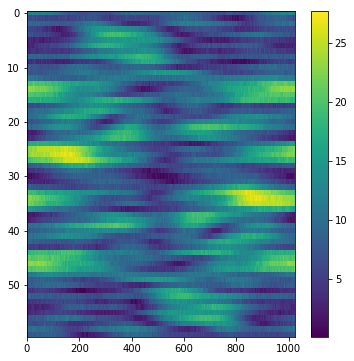

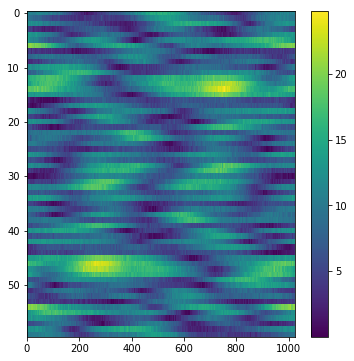

In [62]:

data = v.get_data(23,71,'xx')

plt.figure(figsize=(6,6))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()



data = v.get_data(36,87,'xx')

plt.figure(figsize=(6,6))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()

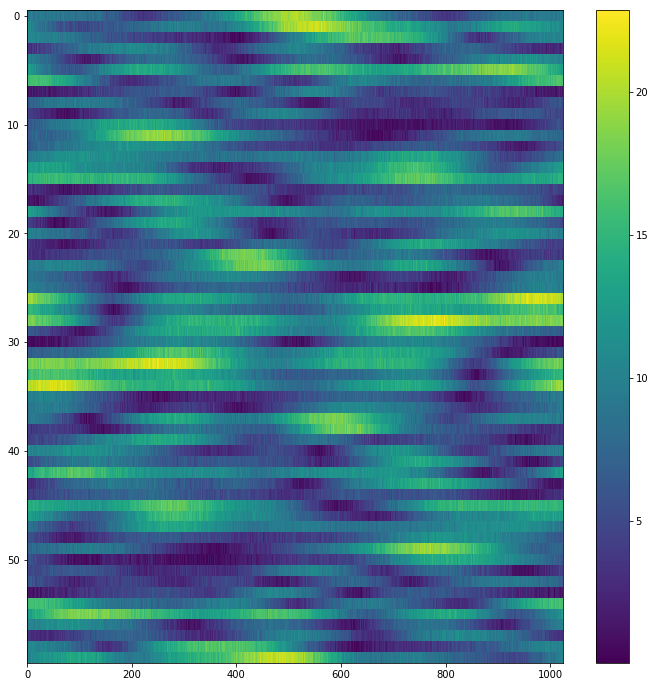

In [63]:

data = v.get_data(37,88,'xx')

plt.figure(figsize=(12,12))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


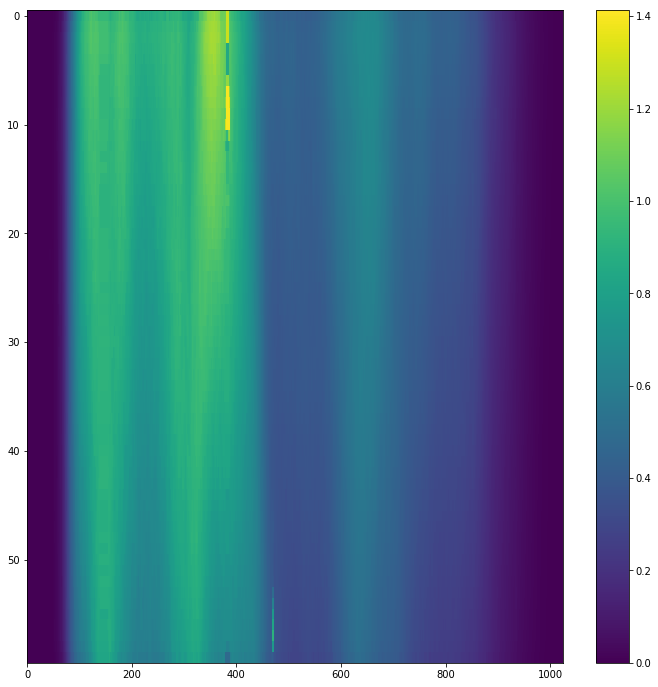

In [93]:

data = v_mod.get_data(0,13,'xx')

foo = medfilt2d(np.abs(data),(5,5))

plt.figure(figsize=(12,12))
#plt.imshow(np.abs(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=40,linthresh=.1))
plt.imshow(foo, aspect='auto')
#plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


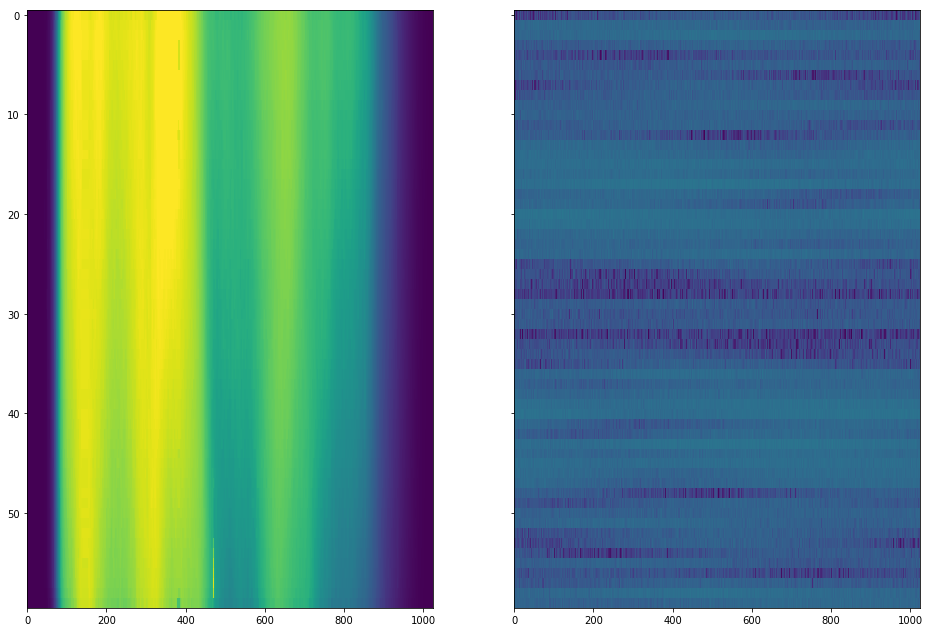

In [94]:
ant_1 = 0
ant_2 = 13

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize =(16,11))
data_sim = v.get_data(ant_1,ant_2,'xx')
data_real = v_mod.get_data(ant_1,ant_2,'xx')

ax1.imshow(np.abs(foo), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.4))
#ax1.imshow(np.abs(np.fft.fftn(data_real)), aspect='auto')
#ax2.imshow(np.abs(np.fft.fftn(data_sim)), aspect='auto')
ax2.imshow(np.abs(data_sim), aspect='auto', norm=SymLogNorm(vmin=0,vmax=10000,linthresh=.4))
plt.show()


In [41]:
am.data.data_array = new_data_array
am.xants = []

In [18]:
z_scores = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants)

In [19]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [20]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


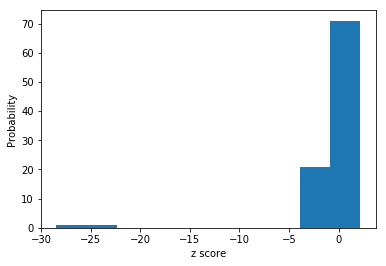

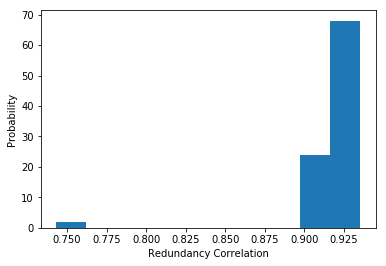

In [21]:
plt.hist(values)
plt.xlabel('z score')
plt.ylabel('Probability')
#plt.xlim(-2,2)
plt.show()

plt.hist(values_raw)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

In [28]:

am.iterative_antenna_metrics_and_flagging(crossCut = 5,deadCut = 5)

print am.xants


[(23, 'y'), (23, 'x')]


In [29]:

def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    
    if ants is None:
        
        ants = list(set([key[0] for key in metrics.keys()]))
        
    if antpols is None:
        
        antpols = list(set([key[1] for key in metrics.keys()]))
        
    for antpol in antpols:
        
        for i,ant in enumerate(ants):
            
            metric = 0
            
            if metrics.has_key((ant,antpol)):
                
                metric = metrics[(ant,antpol)]
                
            plt.plot(i,metric,'.')
            
            plt.annotate(str(ant) + antpol, xy = (i,metrics[(ant,antpol)]))
            
        plt.gca().set_prop_cycle(None)
        
    plt.title(title)
    
    plt.xlabel(xlabel)
    
    plt.ylabel(ylabel)
    
    plt.show()
        

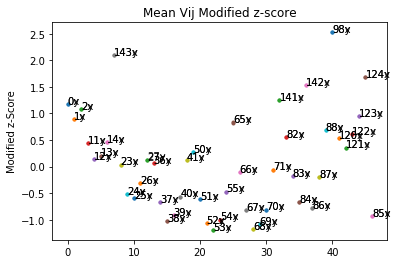

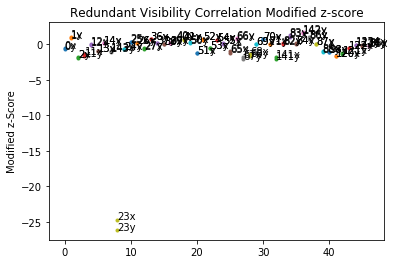

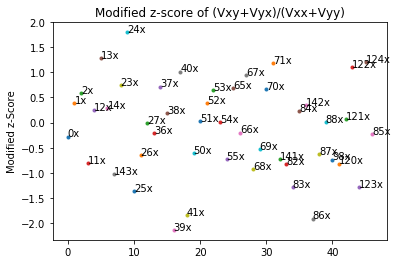

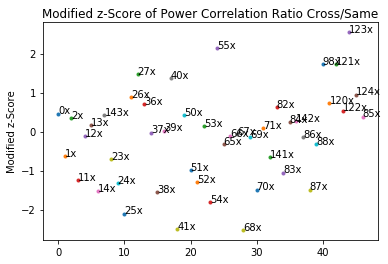

In [30]:

plt.figure()

plot_metric(am.finalModzScores['meanVij'],title='Mean Vij Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['redCorr'],title = 'Redundant Visibility Correlation Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['meanVijXPol'],antpols = ['x'], title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()

plot_metric(am.finalModzScores['redCorrXPol'], antpols = ['x'], title = 'Modified z-Score of Power Correlation Ratio Cross/Same')


In [ ]:
z_scores = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants)

In [ ]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [ ]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


In [ ]:
plt.hist(values)
plt.xlabel('z score')
plt.ylabel('Probability')
#plt.xlim(-2,2)
plt.show()

plt.hist(values_raw)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

## Manually Removing the RFI

In [12]:
print np.where(uv.data_array[0,0,:,0] >= 40)

(array([  61,   62,  109,  110,  111,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127,  128,
        129,  130,  131,  132,  133,  134,  135,  136,  137,  138,  139,
        140,  141,  142,  143,  144,  145,  146,  147,  148,  149,  150,
        151,  152,  153,  154,  155,  156,  157,  158,  159,  160,  161,
        162,  163,  164,  165,  166,  167,  168,  169,  170,  171,  172,
        173,  174,  175,  176,  177,  178,  179,  180,  181,  182,  183,
        184,  185,  186,  187,  188,  189,  190,  191,  192,  193,  194,
        195,  196,  197,  198,  199,  200,  201,  202,  203,  204,  205,
        206,  207,  208,  209,  210,  211,  212,  213,  214,  215,  216,
        217,  218,  219,  220,  221,  222,  223,  224,  225,  226,  227,
        228,  229,  230,  231,  232,  233,  234,  235,  236,  237,  238,
        239,  240,  241,  242,  243,  244,  245,  246,  247,  248,  249,
        250,  251,  252,  253,  254,  255,  256,  

In [13]:
v_mod = deepcopy(uv)

In [14]:
test = v_mod.data_array

In [15]:

for i in range(uv.data_array.shape[0]):
    
    for j in range(uv.data_array.shape[3]):
        
        test[i,0,62,j] = (test[i,0,60,j]+test[i,0,63,j])/2.
        test[i,0,61,j] = (test[i,0,60,j]+test[i,0,63,j])/2.

        test[i,0,379,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,380,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,381,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,382,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,383,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,384,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        test[i,0,385,j] = (test[i,0,386,j]+test[i,0,378,j])/2.
        
        test[i,0,138,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,139,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,140,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,141,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,142,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,143,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,144,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,145,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,146,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,147,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,148,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,149,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,150,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,151,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,152,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,153,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        test[i,0,154,j] = (test[i,0,137,j]+test[i,0,155,j])/2.
        
        test[i,0,1023,j] = test[i,0,1022,j]


In [77]:

for i in nonreds:
    
    ant_1 = i[0]
    
    ant_2 = i[1]

    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    print dist


0.0
102.26090012
124.820393146
0.0
110.292395372
0.0
119.575573237
105.343428766
114.102587093
0.0
0.0
0.0
105.345292326
0.0
115.953072959
95.7977338127
0.0
0.0
0.0
0.0
102.257131738
0.0
114.093570141
0.0
0.0
0.0
0.0
0.0
101.209825051
0.0
114.094163747
0.0
0.0
0.0
0.0
0.0
0.0
102.255216
0.0
102.255599724
0.0
0.0
0.0
0.0
0.0
0.0
105.340136958
0.0
0.0
0.0
0.0
0.0
0.0
95.7915167348
0.0
110.288288029
0.0
110.287409816
105.340700224
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
